In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (f1_score, 
                             roc_auc_score, 
                             precision_score, 
                             precision_recall_curve, 
                            )

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_metrics(y_test, preds):
    
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    
    return roc_auc_score(y_test, preds), precision[ix], recall[ix], fscore[ix], thresholds[ix]

#### 1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice

   1. Wife's age                     (numerical)
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical)
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use, 2=Long-term, 3=Short-term

In [3]:
data = pd.read_csv('./data/cmc.data', header=None)
data = data.sample(frac=1, random_state=42)
data.columns = ['w_age', 'w_ed', 'h_ed', 'n_children', 'w_relig', 'w_working', 
                'h_occupation', 'std_liv_idx', 'media_expos', 'contr_mtd']

In [4]:
cont_columns = ['w_age', 'n_children']
cat_columns = ['w_ed', 'h_ed',  'h_occupation', 'std_liv_idx']
bin_columns = ['w_relig', 'w_working', 'media_expos']

#### 2. сделать feature engineering

In [5]:
data.shape

(1473, 10)

In [6]:
data.duplicated().sum()

48

target: 0 - Long-term или Short-term, 1 - No-use

In [7]:
data['target'] = data['contr_mtd'].where(data['contr_mtd'] == 1, 0)
data.head()

,w_age,w_ed,h_ed,n_children,w_relig,w_working,h_occupation,std_liv_idx,media_expos,contr_mtd,target
852,29,3,3,4,1,1,3,4,0,3,0
184,35,3,4,5,1,0,2,2,0,1,1
1261,23,4,4,1,0,1,1,4,0,2,0
67,30,2,3,3,1,1,3,1,0,1,1
220,22,2,3,1,1,1,3,3,0,1,1


In [8]:
data['target'].value_counts()

0    844
1    629
Name: target, dtype: int64

In [9]:
# пропусков нет
data.isna().sum()

w_age           0
w_ed            0
h_ed            0
n_children      0
w_relig         0
w_working       0
h_occupation    0
std_liv_idx     0
media_expos     0
contr_mtd       0
target          0
dtype: int64

In [10]:
data.describe()

,w_age,w_ed,h_ed,n_children,w_relig,w_working,h_occupation,std_liv_idx,media_expos,contr_mtd,target
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,32.538357,2.958588,3.429735,3.261371,0.850645,0.749491,2.137814,3.133741,0.073999,1.919891,0.427020
std,8.227245,1.014994,0.816349,2.358549,0.356559,0.433453,0.864857,0.976161,0.261858,0.876376,0.494813
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,0.000000,1.000000,0.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000,0.000000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000,1.000000
max,49.000000,4.000000,4.000000,16.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000,1.000000


In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['contr_mtd', 'target'], axis=1), 
                                                    data['target'], random_state=0)

In [12]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True);

##### Вещественные признаки

распределения вещественных признаков - близко к нормальному:

array([[<AxesSubplot: title={'center': 'w_age'}>,
        <AxesSubplot: title={'center': 'n_children'}>]], dtype=object)

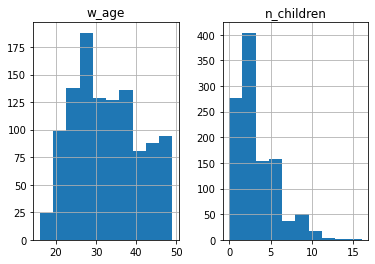

In [13]:
X_train[cont_columns].hist()

- признаки **w_age_log** и **n_children_sqrt** с соответствующими преобразованиями

In [14]:
X_train['w_age_log'] = np.log(X_train['w_age'])
X_train['n_children_sqrt'] = np.sqrt(X_train['n_children'])    

X_test['w_age_log'] = np.log(X_test['w_age'])
X_test['n_children_sqrt'] = np.sqrt(X_test['n_children'])

##### Категориальные признаки

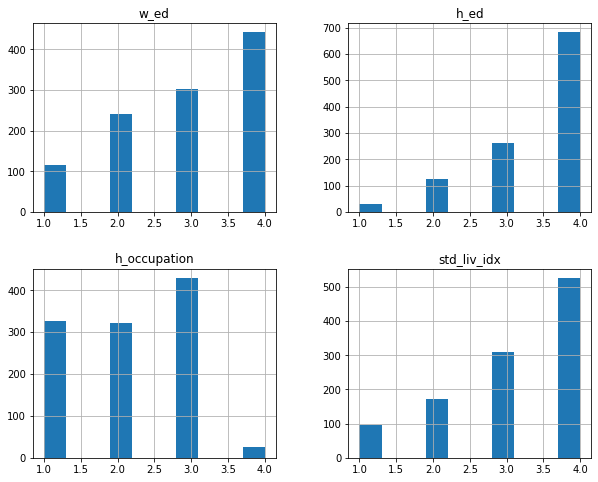

In [15]:
X_train[cat_columns].hist(figsize=(10, 8));

- onehot-кодирование для всех категориальных признаков

In [16]:
X_train = pd.concat([X_train, 
                     *[pd.get_dummies(X_train[cat], prefix=cat) for cat in cat_columns]],
                     axis=1)
X_test = pd.concat([X_test, 
                     *[pd.get_dummies(X_test[cat], prefix=cat) for cat in cat_columns]],
                     axis=1)

- среднее число детей по бинам w_ed и h_ed

In [17]:
childs_per_w_ed = (X_train.groupby('w_ed', as_index=False)
                   .agg(childs_per_w_ed=('n_children', 'mean')))
childs_per_w_ed

,w_ed,childs_per_w_ed
0,1,4.431034
1,2,3.516529
2,3,3.303630
3,4,2.830700


In [18]:
X_train = X_train.merge(childs_per_w_ed, on=['w_ed'], how='left')
X_test = X_test.merge(childs_per_w_ed, on=['w_ed'], how='left')

In [19]:
# X_test.isna().sum().sum()

In [20]:
childs_per_h_ed = (X_train.groupby('h_ed', as_index=False)
                   .agg(childs_per_h_ed=('n_children', 'mean')))
childs_per_h_ed

,h_ed,childs_per_h_ed
0,1,4.750000
1,2,3.833333
2,3,3.629771
3,4,2.973684


In [21]:
X_train = X_train.merge(childs_per_h_ed, on=['h_ed'], how='left')
X_test = X_test.merge(childs_per_h_ed, on=['h_ed'], how='left')

In [22]:
# X_test.isna().sum().sum()

- n_children и std_liv_idx - отрицательно коррелируют с таргетом

In [23]:
# лучшая комбинация из нескольких
(1/(X_train['n_children']+1) + 1/ X_train['std_liv_idx']).corr(y_train)

0.28852945643479033

In [24]:
X_train['child+std_idx'] = 1/(X_train['n_children']+1) + 1/ X_train['std_liv_idx']
X_test['child+std_idx'] = 1/(X_test['n_children']+1) + 1/ X_test['std_liv_idx']

In [25]:
# pd.concat([X_train, y_train], axis=1).corr()

##### Бинарные признаки

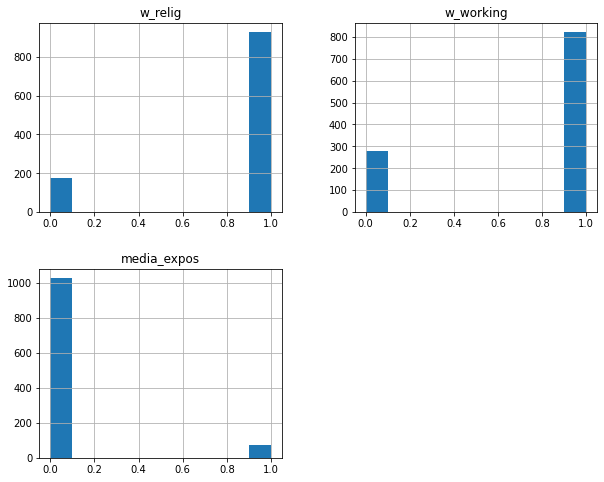

In [26]:
X_train[bin_columns].hist(figsize=(10, 8));

w_relig, w_working - выраженный дисбаланс, media_expos - крайне выраженный дисбаланс, 

- комбинация w_ed, w_working и media_expos

In [27]:
((X_train['w_ed'] + X_train['w_working'])/(X_train['media_expos']+1)).corr(y_train)

-0.2506397242159103

In [28]:
X_train['ed_work_media'] = (X_train['w_ed'] + X_train['w_working'])/(X_train['media_expos']+1)
X_test['ed_work_media'] = (X_test['w_ed'] + X_test['w_working'])/(X_test['media_expos']+1)

In [29]:
# X_test.isna().sum().sum()

##### Простой отбор

In [30]:
st_sc = StandardScaler()

X_train_st = st_sc.fit_transform(X_train)
X_test_st = st_sc.transform(X_test)

In [31]:
lr = LogisticRegression(penalty='l1', C=0.22, solver='saga', max_iter=400,
                        class_weight='balanced', random_state=42)

lr.fit(X_train_st, y_train)
preds_lr = lr.predict_proba(X_test_st)[:, 1]

roc_auc, prec, rec, f_score, th = get_metrics(y_test, preds_lr)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 0.7797, prec: 0.6852, rec: 0.7025, f-score: 0.6937, th: 0.4776


In [32]:
feat_imp = pd.DataFrame({'feat': X_train.columns, 
              'lr': lr.coef_[0]})
feat_imp.sort_values('lr', key=lambda x: abs(x), ascending=False)

,feat,lr
29,child+std_idx,1.562540
0,w_age,0.752009
23,std_liv_idx_1,-0.503158
1,w_ed,-0.428089
7,std_liv_idx,0.415569
14,w_ed_4,-0.173761
4,w_relig,0.138524
6,h_occupation,-0.102687
25,std_liv_idx_3,0.087329
8,media_expos,0.069382


In [33]:
features = feat_imp.loc[abs(feat_imp['lr']) > 0, 'feat']
features.values

array(['w_age', 'w_ed', 'w_relig', 'w_working', 'h_occupation',
       'std_liv_idx', 'media_expos', 'n_children_sqrt', 'w_ed_2',
       'w_ed_4', 'h_ed_1', 'h_ed_2', 'h_ed_3', 'h_occupation_2',
       'h_occupation_4', 'std_liv_idx_1', 'std_liv_idx_3',
       'child+std_idx'], dtype=object)

In [34]:
# features = ['w_age', 'w_ed', 'w_relig', 'w_working', 'h_occupation', 'std_liv_idx', 
#             'media_expos', 'n_children_sqrt', 'w_ed_2', 'w_ed_4', 'h_ed_1', 'h_ed_2', 'h_ed_3', 
#             'h_occupation_2', 'h_occupation_4', 'std_liv_idx_1', 'std_liv_idx_3', 'child+std_idx']

##### Pipeline

In [35]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
     
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


In [36]:
all_transformers = []
# без изменений
base_cols = ['w_age', 'w_ed', 'w_relig', 'w_working', 'h_occupation', 'std_liv_idx', 
            'media_expos']
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col)),
            ])
    all_transformers.append((base_col, base_transformer))

# sqrt - n_children_sqrt
sqrt_transf = Pipeline([
                ('selector', NumberSelector(key='n_children')),
                ('sqrt_transformer', FunctionTransformer(np.sqrt))
            ])
all_transformers.append(('n_children_sqrt', sqrt_transf))

# onehot
onehot_cols = ['w_ed', 'h_ed', 'h_occupation', 'std_liv_idx']
for cat_col in onehot_cols:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    all_transformers.append((f'{cat_col}_onehot', cat_transformer))
    
# child+std_idx
child_std_transformer = Pipeline([
    ('selector', FeatureSelector(column=['n_children', 'std_liv_idx'])),
    ('child_std_transformer', 
         FunctionTransformer(lambda x: pd.DataFrame((1/(x.iloc[:, 0]+1) + 1/x.iloc[:, 1]))))
])
all_transformers.append(('child+std_idx', child_std_transformer))

feats = FeatureUnion(all_transformers)

In [37]:
# feats_all = ['w_age', 'w_ed', 'w_relig', 'w_working', 'h_occupation', 'std_liv_idx', 
#              'media_expos', 'n_children_sqrt', 'w_ed_1', 'w_ed_2', 'w_ed_3', 'w_ed_4', 
#              'h_ed_1', 'h_ed_2', 'h_ed_3', 'h_ed_4', 'h_occupation_1', 'h_occupation_2',
#              'h_occupation_3', 'h_occupation_4', 'std_liv_idx_1', 'std_liv_idx_2',
#              'std_liv_idx_3', 'std_liv_idx_4', 'child+std_idx']

#### 3. обучить любой классификатор (какой вам нравится)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['contr_mtd', 'target'], axis=1), 
                                                    data['target'], random_state=0)

In [39]:
pipeline_abc = Pipeline([
    ('features',feats),
    ('clf', AdaBoostClassifier(random_state=42)),
])

In [40]:
params = {'clf__n_estimators': np.arange(40, 60, 5),
          'clf__learning_rate': np.linspace(0.5, 1.2, num=10)}


grid = GridSearchCV(pipeline_abc, 
                    param_grid=params, 
                    scoring='roc_auc', 
                    n_jobs=-1, 
                    cv=5, 
                    refit=False)

search = grid.fit(X_train, y_train)
best_params = search.best_params_
best_params

{'clf__learning_rate': 0.5777777777777777, 'clf__n_estimators': 40}

Итоговый pipeline

In [41]:
pipeline_abc.set_params(**best_params);

pipeline_abc.fit(X_train, y_train)

preds_abc = pipeline_abc.predict_proba(X_test)[:, 1]
roc_auc, prec, rec, f_score, th = get_metrics(y_test, preds_abc)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 0.7965, prec: 0.6629, rec: 0.7468, f-score: 0.7024, th: 0.4947


In [42]:
metrics = pd.DataFrame({'roc_auc': [], 
                        'precision': [],
                        'recall': [],
                        'f-score': []})

metrics.loc['SL'] = [roc_auc, prec, rec, f_score]
metrics

,roc_auc,precision,recall,f-score
SL,0.796463,0.662921,0.746835,0.702381


#### 4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

In [43]:
np.random.seed(42)

In [44]:
rns_data = X_train.copy()
rns_data['target'] = y_train
rns_data.reset_index(drop=True, inplace=True)

p_idx = np.where(rns_data['target'].values == 1)[0]
np.random.shuffle(p_idx)

In [45]:
perc = 0.5
p_sample_len = int(np.ceil(perc * len(p_idx)))
p_sample_len, len(p_idx)

(236, 471)

In [46]:
p_sample = p_idx[:p_sample_len]
p_sample[:10]

array([ 142,  174,   85, 1041,  998,  578,  517,   25,  858,  169],
      dtype=int64)

In [47]:
rns_data['PU_label'] = 0
rns_data.loc[p_sample, 'PU_label'] = 1
rns_data['PU_label'].value_counts()

0    868
1    236
Name: PU_label, dtype: int64

In [48]:
rns_data.head()

,w_age,w_ed,h_ed,n_children,w_relig,w_working,h_occupation,std_liv_idx,media_expos,target,PU_label
0,26,2,2,3,1,1,2,1,0,1,1
1,46,3,4,4,1,0,3,4,0,0,0
2,47,4,4,8,1,1,1,4,0,0,0
3,28,4,4,1,0,0,2,4,0,0,0
4,28,3,4,2,1,1,2,3,0,0,0


#### 5. применить random negative sampling для построения классификатора в новых условиях

In [49]:
rns_data = rns_data.sample(frac=1)

data_N = rns_data[rns_data['PU_label'] == 0]
data_P = rns_data[rns_data['PU_label'] == 1]

neg_sample = data_N[:data_P.shape[0]]
pos_sample = data_P.copy()

print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
target_train = sample_train['PU_label']

(236, 11) (236, 11)


In [50]:
sample_train.shape, target_train.shape

((472, 11), (472,))

In [51]:
pipeline_abc.fit(sample_train, target_train)

preds_abc = pipeline_abc.predict_proba(X_test)[:, 1]
roc_auc, prec, rec, f_score, th = get_metrics(y_test, preds_abc)
print(f'roc_auc: {roc_auc:.4f}, prec: {prec:.4f}, rec: {rec:.4f},'
      f' f-score: {f_score:.4f}, th: {th:.4f}')

roc_auc: 0.7766, prec: 0.5685, rec: 0.8671, f-score: 0.6867, th: 0.4957


#### 6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)

In [52]:
metrics.loc['PU, perc=0.5'] = [roc_auc, prec, rec, f_score]
metrics

,roc_auc,precision,recall,f-score
SL,0.796463,0.662921,0.746835,0.702381
"PU, perc=0.5",0.776606,0.568465,0.867089,0.686717


У обучения на полностью размеченных данных - чуть лучше метрики.

#### 7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [53]:
for perc in [0.9, 0.75, 0.25, 0.1]:
    p_sample_len = int(np.ceil(perc * len(p_idx)))
    p_sample = p_idx[:p_sample_len]
    rns_data['PU_label'] = 0
    rns_data.loc[p_sample, 'PU_label'] = 1
    rns_data = rns_data.sample(frac=1)

    data_N = rns_data[rns_data['PU_label'] == 0]
    data_P = rns_data[rns_data['PU_label'] == 1]

    neg_sample = data_N[:data_P.shape[0]]
    pos_sample = data_P.copy()

    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    target_train = sample_train['PU_label']
    
    pipeline_abc.fit(sample_train, target_train)

    preds_abc = pipeline_abc.predict_proba(X_test)[:, 1]
    roc_auc, prec, rec, f_score, th = get_metrics(y_test, preds_abc)
    metrics.loc[f'PU, perc={perc}'] = [roc_auc, prec, rec, f_score]

In [54]:
metrics

,roc_auc,precision,recall,f-score
SL,0.796463,0.662921,0.746835,0.702381
"PU, perc=0.5",0.776606,0.568465,0.867089,0.686717
"PU, perc=0.9",0.761008,0.546559,0.854430,0.666667
"PU, perc=0.75",0.785215,0.626316,0.753165,0.683908
"PU, perc=0.25",0.726228,0.571429,0.835443,0.678663
"PU, perc=0.1",0.697357,0.545872,0.753165,0.632979


С уменьшением доли размеченных P-экземпляров метрики довольно плавно снижаются. Интересно, что при perc = 0.9 модель выдаёт несколько худшие метрики. Возможно, это связано с попаданием неудачных экземпляров (выбросов) в выборку при разбиении и перемешивании (при замене np.random.seed(42) метрики ведут себя более предсказуемым образом).